# 1. проведем разведовательный анализ (EDA) данных, предоставленных в проекте в виде тестового датасета
для начала импортируем используемые библиотеки

In [529]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import style
%matplotlib inline
import seaborn as sns 

import plotly
import plotly.express as px
import plotly.graph_objects as go
import cufflinks as cf
import plotly.offline as pyo
from plotly.offline import init_notebook_mode,plot,iplot

from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from pandas import Series
from sklearn.feature_selection import f_classif, mutual_info_classif

In [401]:
test = pd.read_csv('test.csv')
test.sample(3)

,bodyType,brand,car_url,color,complectation_dict,description,engineDisplacement,enginePower,equipment_dict,fuelType,...,vehicleConfiguration,vehicleTransmission,vendor,Владельцы,Владение,ПТС,Привод,Руль,Состояние,Таможня
6648,внедорожник 5 дв.,VOLVO,https://auto.ru/cars/used/sale/volvo/xc90/1090...,чёрный,NaN,Автомобиль имеет два дополнительных места в ба...,2.4 LTR,185 N12,"{""cruise-control"":true,""wireless-charger"":true...",дизель,...,ALLROAD_5_DOORS AUTOMATIC 2.4,автоматическая,EUROPEAN,3 или более,6 лет,Оригинал,полный,Левый,Не требует ремонта,Растаможен
9382,лифтбек,BMW,https://auto.ru/cars/used/sale/bmw/5er/1101140...,чёрный,NaN,\nАвтомобиль был куплен в апреле 2014 года за ...,3.0 LTR,258 N12,"{""cruise-control"":true,""e-adjustment-wheel"":tr...",дизель,...,LIFTBACK AUTOMATIC 3.0,автоматическая,EUROPEAN,1 владелец,NaN,Оригинал,полный,Левый,Не требует ремонта,Растаможен
1497,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/rapid/109...,белый,NaN,"Изготовлена 2017 декабрь, купил у оф.дилера в ...",1.6 LTR,90 N12,"{""gbo"":true}",бензин,...,LIFTBACK MECHANICAL 1.6,механическая,EUROPEAN,1 владелец,2 года и 7 месяцев,Оригинал,передний,Левый,Не требует ремонта,Растаможен


In [17]:
sample = pd.read_csv('sample_submission.csv')
sample.sample(3)

,sell_id,price
4884,1099434854,0
12816,1100042140,0
16955,1101143395,0


In [18]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34686 entries, 0 to 34685
Data columns (total 32 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   bodyType              34686 non-null  object
 1   brand                 34686 non-null  object
 2   car_url               34686 non-null  object
 3   color                 34686 non-null  object
 4   complectation_dict    6418 non-null   object
 5   description           34686 non-null  object
 6   engineDisplacement    34686 non-null  object
 7   enginePower           34686 non-null  object
 8   equipment_dict        24690 non-null  object
 9   fuelType              34686 non-null  object
 10  image                 34686 non-null  object
 11  mileage               34686 non-null  int64 
 12  modelDate             34686 non-null  int64 
 13  model_info            34686 non-null  object
 14  model_name            34686 non-null  object
 15  name                  34686 non-null

как видно из данных, в тестовом датасете нет целевой переменной, которую необходимо предсказать. добавим ее

In [537]:
test['price'] = 1
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 34686 entries, 0 to 34685
Columns: 276 entries, bodyType to price
dtypes: float64(11), int64(15), object(21), uint8(229)
memory usage: 20.3+ MB


добавим функции, которые будут отрисовывать распределение признаков

In [135]:
from matplotlib import rcParams
rcParams['figure.figsize'] = 15, 8 

def categorial_feature(column, data, rotate=90, x_shift_mult=0, percentage=True):

    ax = sns.countplot(x=column,
                       data=data,
                       order=data[column].value_counts().index, orient="h", palette ="Spectral")
    if percentage:
        total = len(data[column])
        for p in ax.patches:
            percentage = '{:.1f}%'.format(100 * p.get_height()/total) #добавим в подпись процентное соотношение
            x = p.get_x() + x_shift_mult*p.get_width()
            y = p.get_y() + p.get_height()+8
            ax.annotate(percentage, (x, y)) 
    plt.xticks(rotation=rotate)


def numeric_feature(data, bins=10):
    print(data.describe()[["min", "max", "25%", "50%", "75%", "std"]])
    sns.distplot(data, bins=bins)

проверим наличие дубликатов и пропусков в тестовом датасете

Дубликаты: 0


complectation_dict    28268
equipment_dict         9996
Владение              22691
ПТС                       1
dtype: int64

None


<AxesSubplot:>

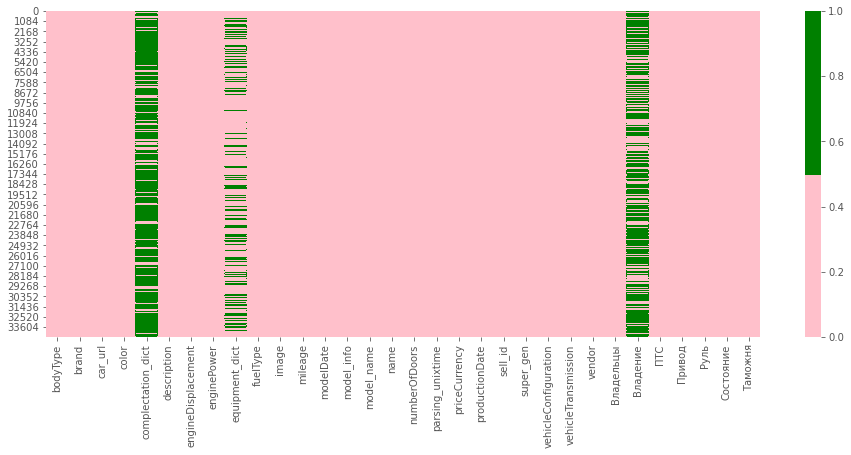

In [278]:
print (f'Дубликаты: {test.duplicated().sum()}')
print (display(test.isna().sum()[test.isna().sum() > 0]))
colours = ['pink', 'green']
plt.figure(figsize=(16, 6))
sns.heatmap(test.isnull(), cmap=sns.color_palette(colours))


как видно - дубликтов в датасете нет, но зато есть признаки с пропусками, при том в некоторыхпоказателях их существенное количество. К ним относятся: complectation_dict, equipment_dict, Владение, ПТС. В дальнейшем их рассмотрим подробнее и примем решение об их использовании. Признак цены был добавлен и там еще нет данных. 

Разделим признаки по видам.
- Категориальные: 'bodyType', 'brand', 'color', 'fuelType', 'model_name', 'priceCurrency', 'vehicleTransmission', 'vendor', 'Владельцы', 'Владение', 'ПТС', 'Привод', 'Руль', 'Состояние', 'Таможня'
- Числовые: 'mileage', 'numberOfDoors', 'sell_id', 'price'
- Временные: 'modelDate', 'productionDate', 'parsing_unixtime'
- Описательные: 'complectation_dict', 'description', 'engineDisplacement', 'enginePower', 'equipment_dict', 'model_info', 'name', 'vehicleConfiguration'

# Категориальные признаки

In [63]:
cat_features = ['bodyType', 'brand', 'color', 'fuelType', 'model_name', 'priceCurrency', 'vehicleTransmission', 'vendor', 
                'Владельцы', 'ПТС', 'Привод', 'Руль', 'Состояние', 'Таможня']

dict_category = {}
for category in cat_features:
    data_category = test[category].value_counts()
    dict_category[category] = len(data_category)

print (dict_category)

{'bodyType': 24, 'brand': 12, 'color': 16, 'fuelType': 5, 'model_name': 544, 'priceCurrency': 1, 'vehicleTransmission': 4, 'vendor': 2, 'Владельцы': 3, 'ПТС': 2, 'Привод': 3, 'Руль': 2, 'Состояние': 1, 'Таможня': 1}


как видно, в основном в признаки имеют относительно небольшое количество вариаций. Но следует отметить, что вариантов моделей автомобилей - 544, что существенно выбивается из общей тенденции. С другой стороны в таких признаках, как таможня, состояние и priceCurrency (валюта) всего по одному варианту, а vendor (производитель), ПТС и Руль - по два. Для дальнейшего EDA-анализа можем их заменить на бинарные
Ранее было обнаружено, что признаке ПТС есть пропуск. Рассмотрим его ближе

In [279]:
test['ПТС'].value_counts()

Оригинал    30098
Дубликат     4587
Name: ПТС, dtype: int64

In [413]:
# заменим пропуск в этом признаке на наиболее часто встречающееся значение
test['ПТС'].fillna(test.ПТС.mode()[0], inplace=True)

### bodyType

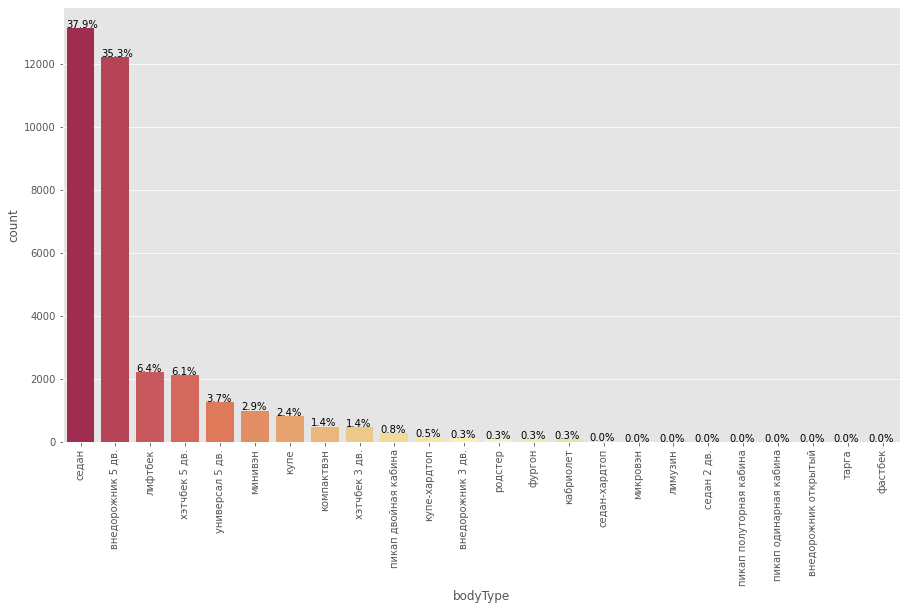

In [122]:
categorial_feature("bodyType", test, rotate=90)

как видно, наиболее распространенные модели кузова - это седан и 5дверный внедорожник

### brand

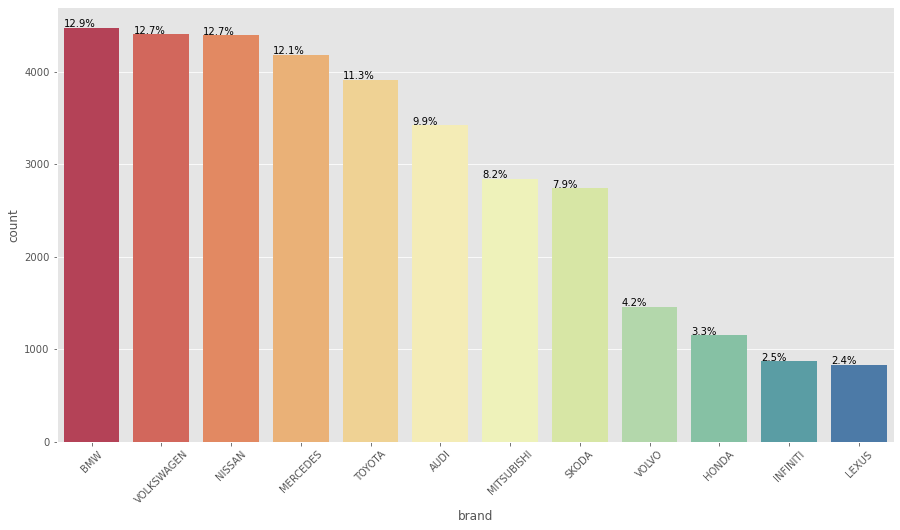

In [123]:
categorial_feature("brand", test, rotate=45)

лидерами по моделям являются БМВ, Фольксвагены и Ниссаны,а также Мерседесы и Тойоты. Люксовых марок авто представлено меньше всего

### color

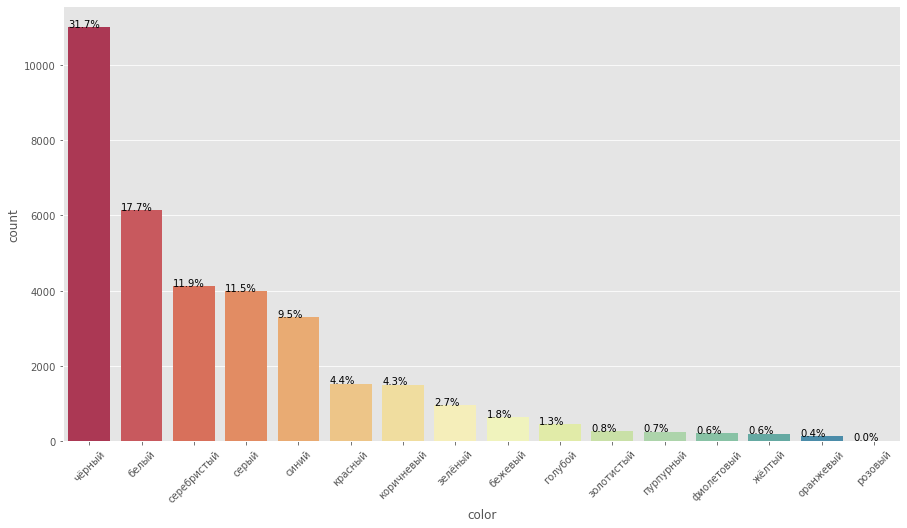

In [124]:
categorial_feature("color", test, rotate=45)

самый распространенный цвет авто - черный

### fuel

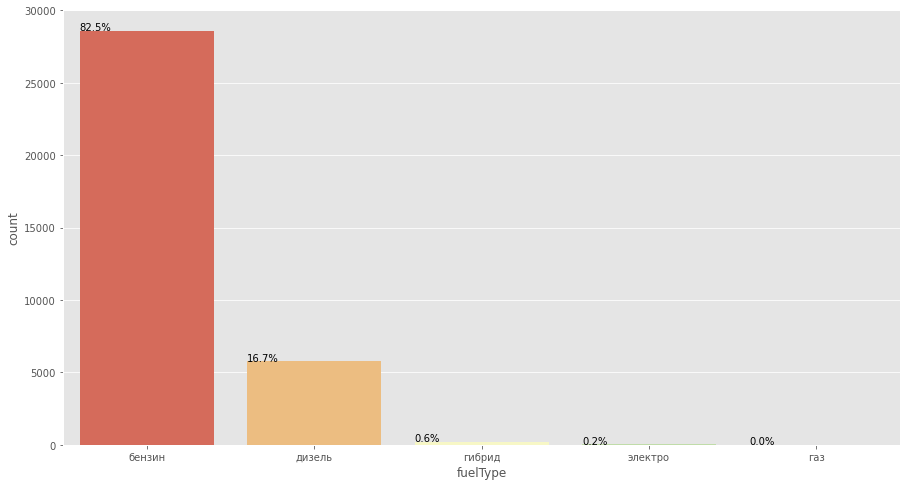

In [126]:
categorial_feature("fuelType", test, rotate=0)

бензиновые двигатели ожидаемо наиболее распространенные среди автомобилей

### transmission

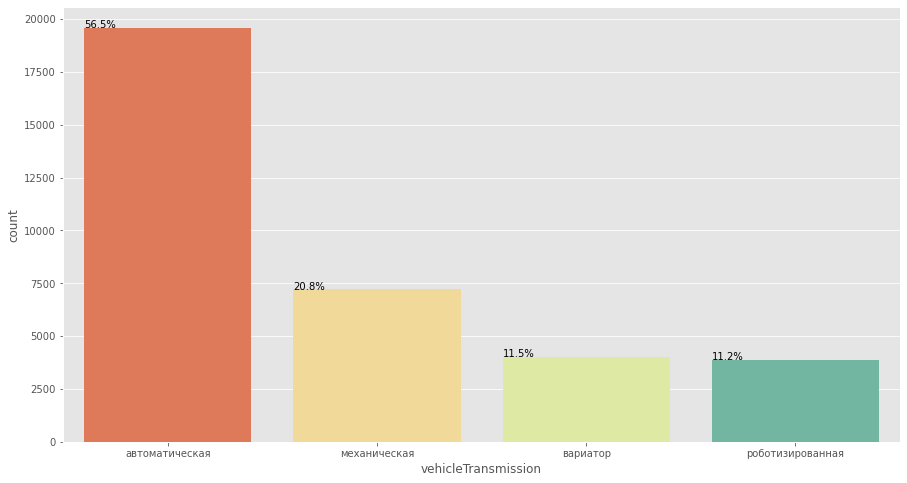

In [127]:
categorial_feature("vehicleTransmission", test, rotate=0)

наиболее часто встречающиеся авто - с АКПП, что обусловлено популярностью иномарок

### vendor

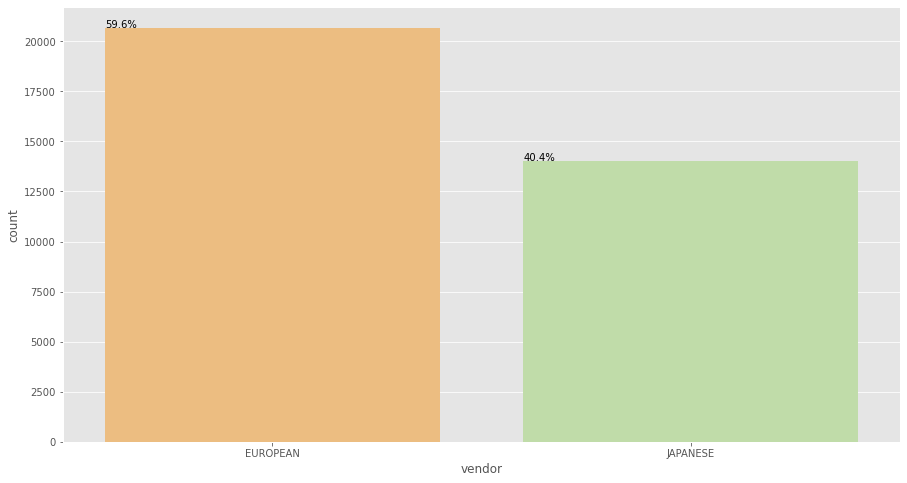

In [128]:
categorial_feature("vendor", test, rotate=0)

In [ ]:
вариантов производителей немного - либо европейские, либо японские

### Владельцы

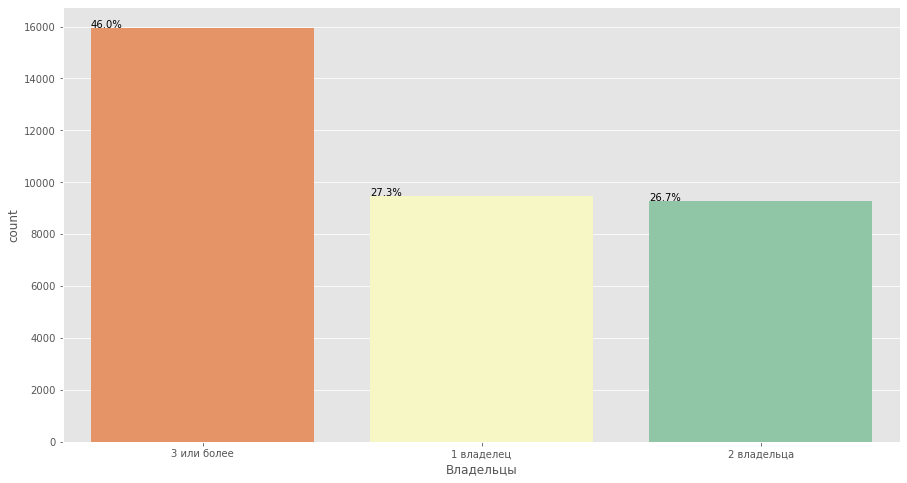

In [313]:
categorial_feature("Владельцы", test, rotate=0)

почти половина авто имеет более 3 владельцев. Т.к этот признак оказывает существенное влияние на цену, преобразуем его, сделаем числовым

In [414]:
owners_dict = {'1\xa0владелец': 1,
               '2\xa0владельца': 2,
               '3 или более': 3
               }
test.Владельцы = test.Владельцы.map(owners_dict)

# Числовые признаки

In [281]:
num_features = ['mileage', 'numberOfDoors']

array([[<AxesSubplot:title={'center':'mileage'}>,
        <AxesSubplot:title={'center':'numberOfDoors'}>]], dtype=object)

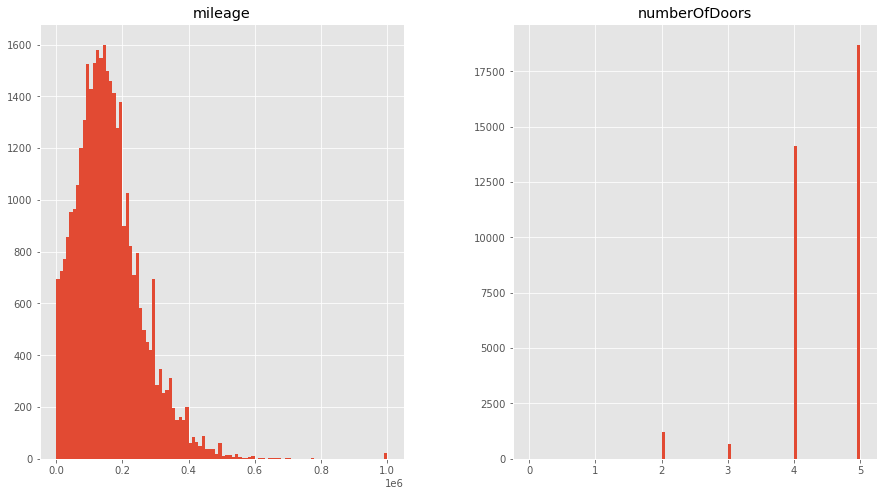

In [282]:
# рассмотрим распределение числовых признаков
test[num_features].hist(figsize=(15, 8), bins=100)

min          1.000000
max    1000000.000000
25%      91153.500000
50%     149779.500000
75%     215000.000000
std     100676.559489
Name: mileage, dtype: float64


C:\Users\007\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



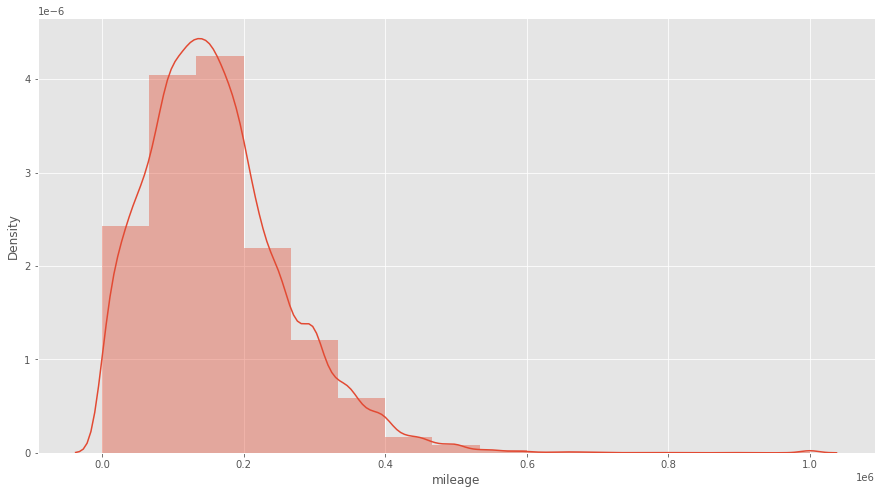

In [283]:
numeric_feature(test.mileage, bins=15)

min    0.00000
max    5.00000
25%    4.00000
50%    5.00000
75%    5.00000
std    0.70304
Name: numberOfDoors, dtype: float64


C:\Users\007\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



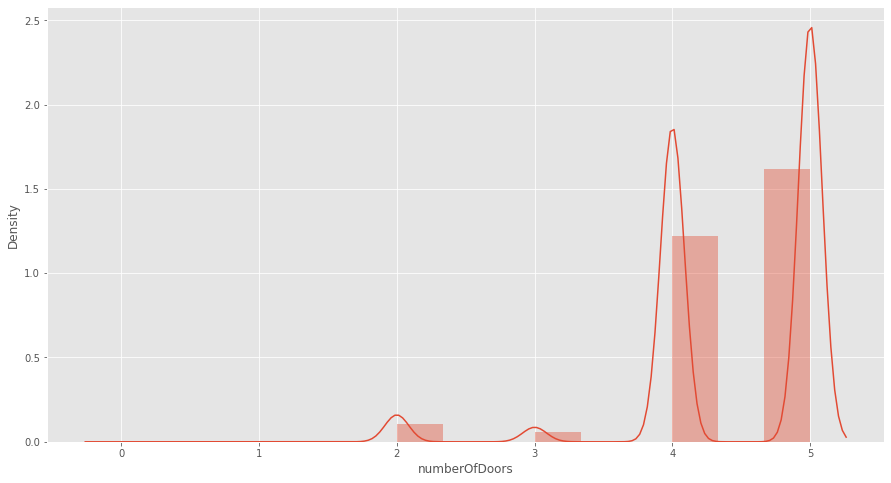

In [142]:
numeric_feature(test.numberOfDoors, bins=15)

На основе этих графиков можно сделать вывод, что пробег состявляет у большинства машин и для некоторых машин в пределе до 200 тыс. км . По второму графику видно, что основные категории составляют 4-5 дверные машины, имеется небольшой процент 2-х и 3-х дверных машин.
Графики для modelDate и productionDate в целом очень похожи. Представленные машины были произведены в период с 1980 по 2020 годы (также имеются и более ранние машины, но их очень мало). Основную массу составляют машины примерно, начиная с 2010 года.

# Временные признаки

In [143]:
date_features = ['modelDate', 'productionDate', 'parsing_unixtime']

min    1904.000000
max    2020.000000
25%    2004.000000
50%    2008.000000
75%    2012.000000
std       7.415894
Name: modelDate, dtype: float64


C:\Users\007\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



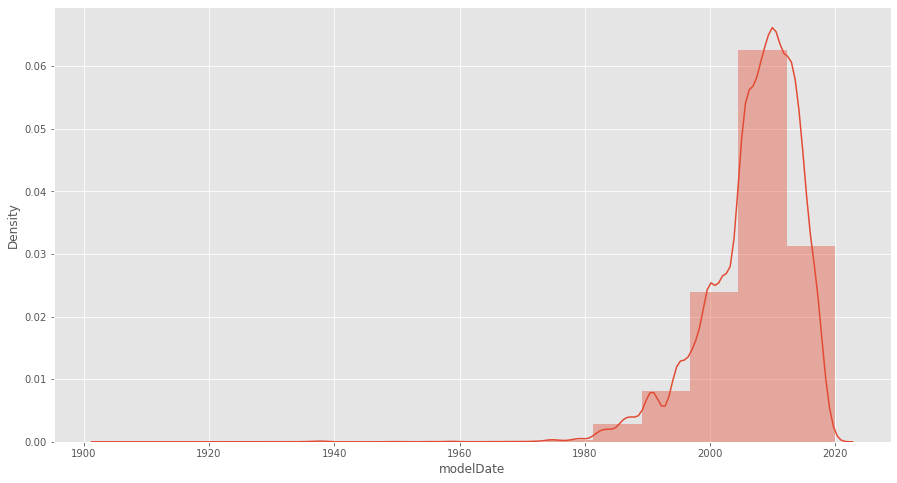

In [284]:
numeric_feature(test.modelDate, bins=15)

min    1904.000000
max    2020.000000
25%    2006.000000
50%    2011.000000
75%    2014.000000
std       7.047661
Name: productionDate, dtype: float64


C:\Users\007\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



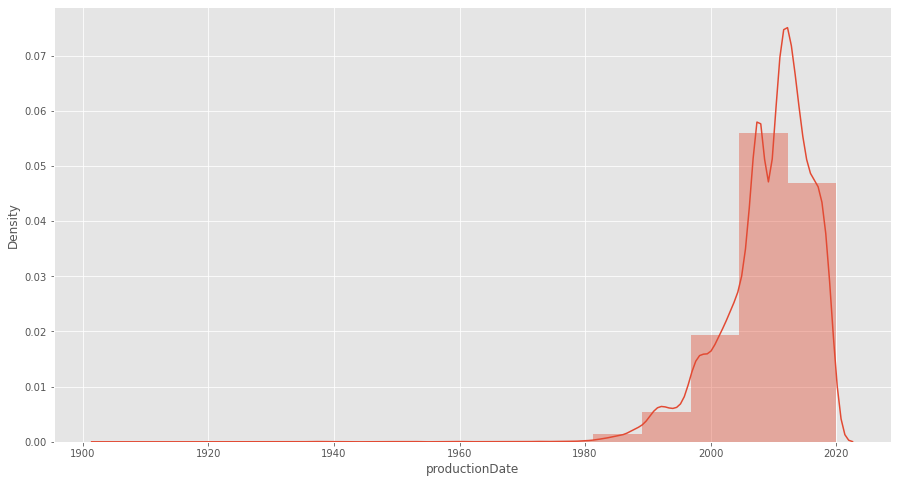

In [146]:
numeric_feature(test.productionDate, bins=15)

Год начала выпуска модели и год начала выпуска марок авто имеет ассиметричное распределение с длинным левым концом. Производство самой старой марки началось в 1904 году, самой новой - в 2020

для дальнейшего использования информации о годах выпуска преобразуем ее в возраст модели и марки автомобилей и добавим в качестве признака в датасет

In [415]:
test['modelAge'] = 2021 - test.modelDate
test['autoAge'] = 2021 - test.productionDate

In [378]:
num_features.append('autoAge')
num_features.append('modelAge')

In [379]:
#добавим преобразованный признак владельцев в список
num_features.append('Владельцы')

# Описательные признаки

In [159]:
desc_features = ['complectation_dict', 'description', 'engineDisplacement', 'enginePower', 'equipment_dict', 
                 'model_info', 'name', 'vehicleConfiguration']

в признаке 'engineDisplacement' 55 значений не заполнены, т.к в целом это количество незначительно, заменим его наиболее часто встречающимся

In [411]:
test['engineDisplacement'] = test['engineDisplacement'].apply(lambda x: '2.0 LTR' if x == ' LTR' else x)

In [418]:
#данные об объеме двигателя и его мощности преобразуем в число, чтобы можно было в дальнейшем с ними рабтать
test.engineDisplacement = test.engineDisplacement.str.findall(r"\d.\d").str[0]
test.engineDisplacement = test.engineDisplacement.astype('float64')

In [341]:
# внесем преобразованные признаки в список числовых
num_features.append('engineDisplacement')

In [419]:
# то же сделаем и с мощностью дигателя
test.enginePower = test.enginePower.str.findall(r'^\S+').str[0]
test.enginePower = test.enginePower.apply(lambda x: int(x))

In [291]:
num_features.append('enginePower')

In [292]:
test[['engineDisplacement', 'enginePower', 'name']]
# в колонке 'name' дублируется информация о мощности и объеме, но там также содержатся и другие данные,
# которые могут быть использованы в дальнейшем

,engineDisplacement,enginePower,name
0,1.2,105,1.2 AMT (105 л.с.)
1,1.6,110,1.6 MT (110 л.с.)
2,1.8,152,DSG 1.8 AMT (152 л.с.)
3,1.6,110,1.6 AT (110 л.с.)
4,1.8,152,1.8 AT (152 л.с.)
...,...,...,...
34681,1.6,136,316i 1.6 AT (136 л.с.)
34682,2.0,190,520d xDrive 2.0d AT (190 л.с.) 4WD
34683,2.5,170,523i 2.5 AT (170 л.с.)
34684,2.0,184,20d 2.0d AT (184 л.с.) 4WD


min     30.000000
max    639.000000
25%    125.000000
50%    169.000000
75%    233.000000
std     89.087035
Name: enginePower, dtype: float64


C:\Users\007\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



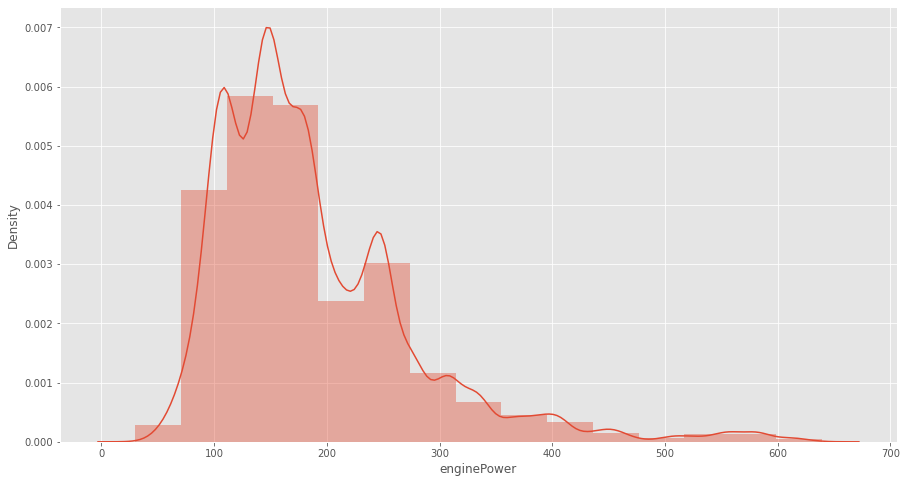

In [293]:
numeric_feature(test.enginePower, bins=15)

как видно, мощность автомобилей ассиметричное распределение с длинным правым концом. Наиболее распространенные машины имеют мощность порядка 170 л.с, самые мощные авто в датасете имеют можность 639 л.с. Эти данныеможно использовать для рассчета транспортного налога. Созадим новый признак, разделив мощность на категории

In [420]:
# налоговая ставка зависит от мощности двигателя. Например, свыше 100 л.с. до 150 л.с. составляет 35 руб
def rate(power):
    if power > 250:
        return 150
    elif power > 200:
        return 75
    elif power > 150:
        return 50
    elif power > 100:
        return 35
    else:
        return 25

def calc_tax(row):
    return rate(row["enginePower"])*row["enginePower"]

test["tax"] = test.apply(lambda row: calc_tax(row), axis=1)

In [295]:
# внесем новый признак в список числовых
num_features.append('tax')

In [225]:
test[['engineDisplacement', 'enginePower', 'tax']]

,engineDisplacement,enginePower,tax
0,1.2,105,3675
1,1.6,110,3850
2,1.8,152,7600
3,1.6,110,3850
4,1.8,152,7600
...,...,...,...
34681,1.6,136,4760
34682,2.0,190,9500
34683,2.5,170,8500
34684,2.0,184,9200


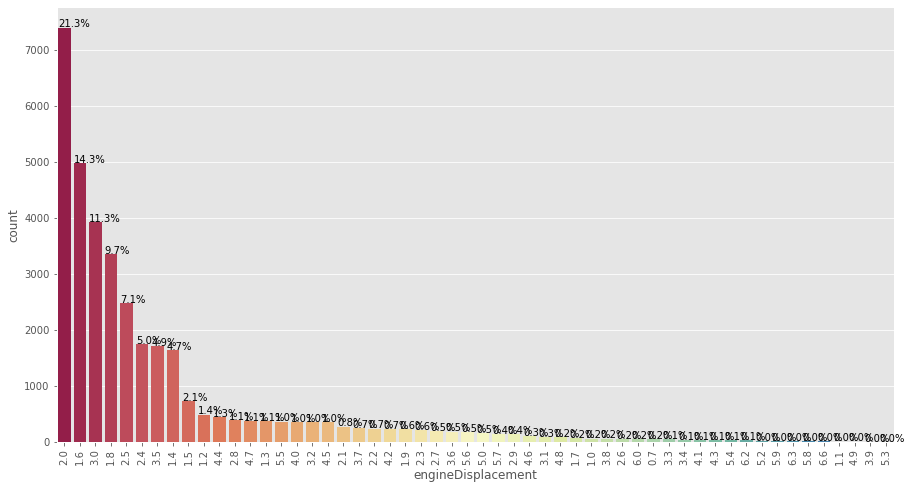

In [214]:
categorial_feature("engineDisplacement", test, rotate=90)

бОльшая часть представленных автомобилей имеют объем двигателя 2,0 л, затем 1,6 и 3,0 соответственно

In [421]:
print (num_features)

['mileage', 'numberOfDoors', 'enginePower', 'tax', 'engineDisplacement', 'modelAge', 'autoAge', 'Владельцы']


In [422]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34686 entries, 0 to 34685
Data columns (total 36 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   bodyType              34686 non-null  object 
 1   brand                 34686 non-null  object 
 2   car_url               34686 non-null  object 
 3   color                 34686 non-null  object 
 4   complectation_dict    6418 non-null   object 
 5   description           34686 non-null  object 
 6   engineDisplacement    34686 non-null  float64
 7   enginePower           34686 non-null  int64  
 8   equipment_dict        24690 non-null  object 
 9   fuelType              34686 non-null  object 
 10  image                 34686 non-null  object 
 11  mileage               34686 non-null  int64  
 12  modelDate             34686 non-null  int64  
 13  model_info            34686 non-null  object 
 14  model_name            34686 non-null  object 
 15  name               

array([[<AxesSubplot:title={'center':'mileage'}>,
        <AxesSubplot:title={'center':'numberOfDoors'}>,
        <AxesSubplot:title={'center':'enginePower'}>],
       [<AxesSubplot:title={'center':'tax'}>,
        <AxesSubplot:title={'center':'modelAge'}>,
        <AxesSubplot:title={'center':'autoAge'}>],
       [<AxesSubplot:title={'center':'engineDisplacement'}>,
        <AxesSubplot:title={'center':'Владельцы'}>, <AxesSubplot:>]],
      dtype=object)

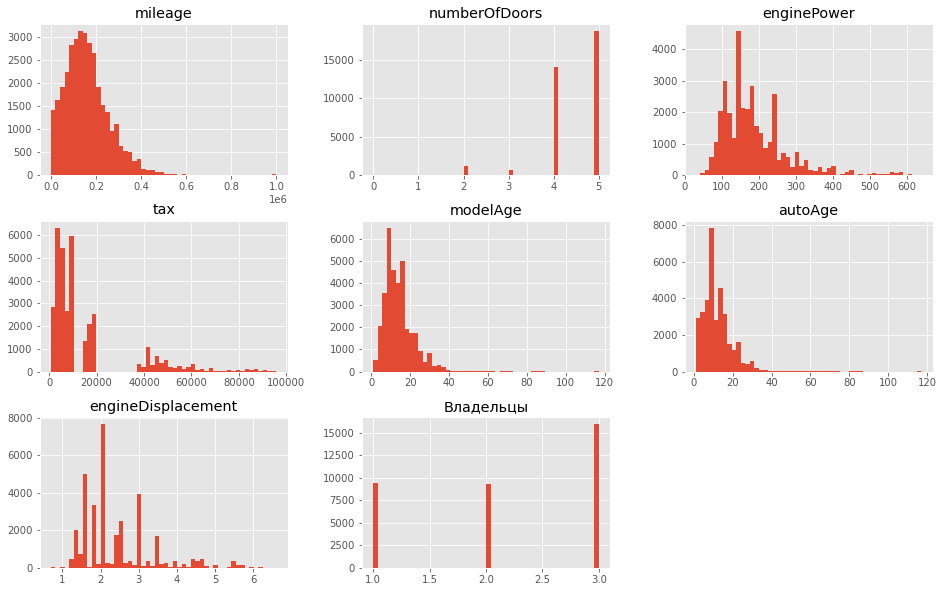

In [352]:
test[num_features].hist(figsize=(16, 10), bins=50)

как видно, почти у всех показателей наблюдается смещение вправо. для того, чтобы распределение было более равномерным, попробуем прологарифировать эти данные

array([[<AxesSubplot:title={'center':'mileage'}>,
        <AxesSubplot:title={'center':'numberOfDoors'}>,
        <AxesSubplot:title={'center':'enginePower'}>],
       [<AxesSubplot:title={'center':'tax'}>,
        <AxesSubplot:title={'center':'modelAge'}>,
        <AxesSubplot:title={'center':'autoAge'}>],
       [<AxesSubplot:title={'center':'engineDisplacement'}>,
        <AxesSubplot:title={'center':'Владельцы'}>, <AxesSubplot:>]],
      dtype=object)

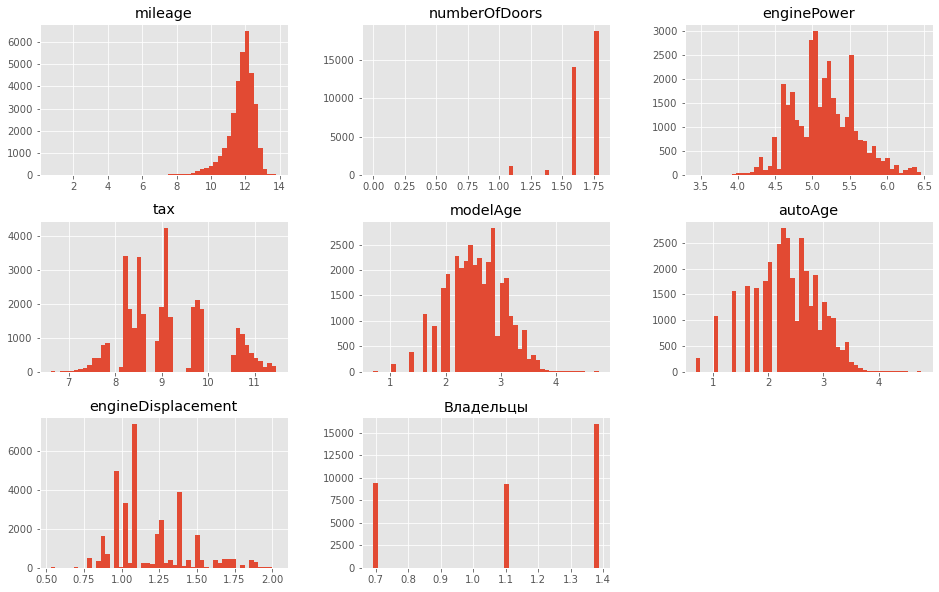

In [354]:
test_log = test.copy()
num_features_log = ['mileage', 'numberOfDoors', 'enginePower', 'tax', 'modelAge', 'autoAge', 'engineDisplacement', 'Владельцы']
for q in num_features_log:
    test_log[q] = test_log[q].apply(lambda w: np.log(w + 1))
    
test_log[num_features_log].hist(figsize=(16, 10), bins=50)

логарифмирование "помогло" показателю возраста модели и возраста авто, а также мощности автомобилей и налога, их распределение 
стало более равномерным, соответственно, можем прологарифмировать эти колонки в общем датасете

In [423]:
test['mileage_log'] = np.log(test['mileage'] + 1)

In [424]:
test['engineDisplacement_log'] = np.log(test['engineDisplacement'] + 1)

In [425]:
test['enginePower_log'] = np.log(test['enginePower'] + 1)

In [426]:
test['tax_log'] = np.log(test['tax'] + 1)

In [427]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34686 entries, 0 to 34685
Data columns (total 40 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   bodyType                34686 non-null  object 
 1   brand                   34686 non-null  object 
 2   car_url                 34686 non-null  object 
 3   color                   34686 non-null  object 
 4   complectation_dict      6418 non-null   object 
 5   description             34686 non-null  object 
 6   engineDisplacement      34686 non-null  float64
 7   enginePower             34686 non-null  int64  
 8   equipment_dict          24690 non-null  object 
 9   fuelType                34686 non-null  object 
 10  image                   34686 non-null  object 
 11  mileage                 34686 non-null  int64  
 12  modelDate               34686 non-null  int64  
 13  model_info              34686 non-null  object 
 14  model_name              34686 non-null

<AxesSubplot:>

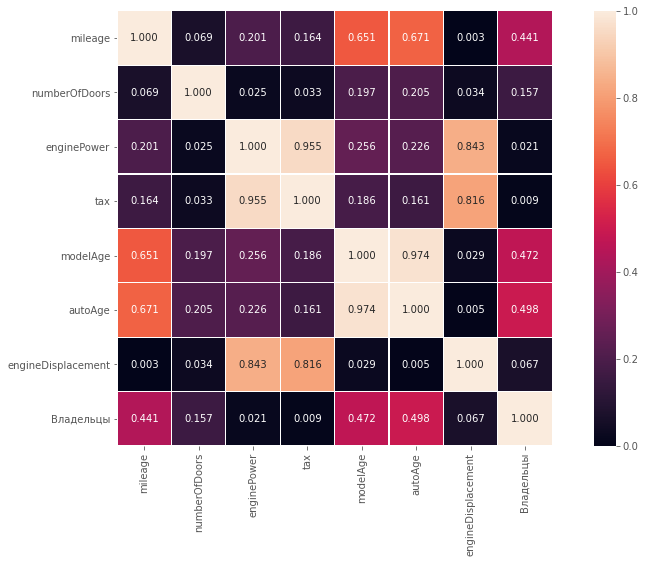

In [360]:
# Посмотрим корреляцию числовых признаков
sns.heatmap(test[num_features].corr().abs(), vmin=0, vmax=1, square=True,
              annot=True, fmt=".3f", linewidths=0.1)

как видно из тепловой карты, наибольшая корреляционная зависимость наблюдается между возрастом модели, годом выпуска авто. А также между мощностью машины и его объемом двигателя, и налогом, как производным признаком от мощности

# Feature Engineering

In [460]:
# преобразуем признаки enginePower и engineDisplacement

pf = PolynomialFeatures(2)
poly_features = pf.fit_transform(test[[ 'engineDisplacement', 'enginePower']])
poly = pd.DataFrame(poly_features).drop([0], axis = 1)
poly.columns = ['displacement_power_1', 'displacement_power_2', 'displacement_power_3', 'displacement_power_4',
              'displacement_power_5']

poly
# num_features = num_features + list(poly.columns)
# test = pd.concat([test, poly], axis=1)
# test.sample(3)

,displacement_power_1,displacement_power_2,displacement_power_3,displacement_power_4,displacement_power_5
0,1.2,105.0,1.44,126.0,11025.0
1,1.6,110.0,2.56,176.0,12100.0
2,1.8,152.0,3.24,273.6,23104.0
3,1.6,110.0,2.56,176.0,12100.0
4,1.8,152.0,3.24,273.6,23104.0
...,...,...,...,...,...
34681,1.6,136.0,2.56,217.6,18496.0
34682,2.0,190.0,4.00,380.0,36100.0
34683,2.5,170.0,6.25,425.0,28900.0
34684,2.0,184.0,4.00,368.0,33856.0


In [467]:
#Аналогично проделаем с другими признаками
pf = PolynomialFeatures(2)
poly_features = pf.fit_transform(test[['autoAge', 'modelAge']])
poly = pd.DataFrame(poly_features.mean(axis=1))
poly.columns = ['auto_model']
test = pd.concat([test, poly], axis=1)
test.sample(3)

,bodyType,brand,car_url,color,complectation_dict,description,engineDisplacement,enginePower,equipment_dict,fuelType,...,mileage_log,engineDisplacement_log,enginePower_log,tax_log,displacement_power_1,displacement_power_2,displacement_power_3,displacement_power_4,displacement_power_5,auto_model
14928,внедорожник 5 дв.,INFINITI,https://auto.ru/cars/used/sale/infiniti/jx/110...,чёрный,NaN,Машиной пользуюсь каждый день.\nЧто было сдела...,3.5,265,NaN,бензин,...,11.842236,1.504077,5.583496,10.590390,3.5,265.0,12.25,927.5,70225.0,43.666667
3650,седан,AUDI,https://auto.ru/cars/used/sale/audi/80/1100954...,серебристый,NaN,Машина на ходу сел и поехал,1.8,90,NaN,бензин,...,12.611541,1.029619,4.510860,7.719130,1.8,90.0,3.24,162.0,8100.0,572.833333
12920,внедорожник 5 дв.,NISSAN,https://auto.ru/cars/used/sale/nissan/x_trail/...,серый,NaN,Автомобиль в очень хорошем состоянии. Покупалс...,2.0,141,"{""engine-proof"":true,""cruise-control"":true,""as...",бензин,...,12.196027,1.098612,4.955827,8.504311,2.0,141.0,4.00,282.0,19881.0,82.833333


некоторые категориальные признаки имеют 2 категории значений, некторые больше. Для признаков, имеющих 2 категории используем функцию LabelEncoder(), для других - OneHotEncoder()/get_dummies()

In [480]:
# с помощью LabelEncoder преобразуем все бинарные переменные в числовые
bin_cols = ['vendor', 'ПТС', 'Руль']
label_encoder = LabelEncoder()
for column in bin_cols:
    test[column] = label_encoder.fit_transform(test[column])

# убедимся в преобразовании    
test[['vendor', 'ПТС', 'Руль']].sample(5)

,vendor,ПТС,Руль
28980,1,0,0
14617,1,0,0
8758,0,1,0
9167,0,1,0
7985,0,1,0


In [543]:
# добавим сразу эти признаки в список числовых
num_features = num_features + bin_cols

In [496]:
# с помощью get_dummies преобразуем в dummy-переменные сохраним в одтельный датафрейм, который затем присоединим к основному
feature = ['bodyType', 'brand', 'color', 'fuelType','vehicleTransmission','Привод']

test2 = pd.get_dummies(test, columns=feature, drop_first=True)
test2.sample(5)

,car_url,complectation_dict,description,engineDisplacement,enginePower,equipment_dict,image,mileage,modelDate,model_info,...,color_чёрный,fuelType_газ,fuelType_гибрид,fuelType_дизель,fuelType_электро,vehicleTransmission_вариатор,vehicleTransmission_механическая,vehicleTransmission_роботизированная,Привод_передний,Привод_полный
30968,https://auto.ru/cars/used/sale/volkswagen/pass...,NaN,Я владелец! в ПТС тоже я! машина в хорошем сос...,2.0,140,"{""engine-proof"":true,""cruise-control"":true,""as...",https://autoru.naydex.net/cSRr96A18/708ec0RhY5...,255000,2005,"{""code"":""PASSAT"",""name"":""Passat"",""ru_name"":""Па...",...,1,0,0,1,0,0,1,0,0,1
15090,https://auto.ru/cars/used/sale/infiniti/fx/108...,NaN,Авто в отличном состоянии и в оригинальном обв...,5.0,420,"{""asr"":true,""tinted-glass"":true,""esp"":true,""ad...",https://autoru.naydex.net/LxPU17803/f5b8d77S/u...,48000,2011,"{""code"":""FX"",""name"":""FX"",""ru_name"":""FX"",""morph...",...,0,0,0,0,0,0,0,0,0,1
8823,https://auto.ru/cars/used/sale/bmw/x6/10512947...,NaN,Своевременное обслуживание. Пройдено ТО на 130...,3.0,306,"{""cruise-control"":true,""asr"":true,""tinted-glas...",https://autoru.naydex.net/lICN99c69/9bc7d3Rr7k...,134000,2007,"{""code"":""X6"",""name"":""X6"",""ru_name"":""Х6"",""morph...",...,0,0,0,0,0,0,0,0,0,1
23295,https://auto.ru/cars/used/sale/volkswagen/jett...,NaN,Только СЕГОДНЯ И ЗАВТРА при покупке этого авто...,1.6,85,"{""cruise-control"":true,""alloy-wheel-disks"":tru...",https://avatars.mds.yandex.net/get-autoru-vos/...,160000,2014,"{""code"":""JETTA"",""name"":""Jetta"",""ru_name"":""Джет...",...,0,0,0,0,0,0,1,0,1,0
17905,https://auto.ru/cars/used/sale/mercedes/gl_kla...,NaN,Комплект зимних шин в подарок.,3.0,249,NaN,https://avatars.mds.yandex.net/get-autoru-vos/...,170000,2012,"{""code"":""GL_KLASSE"",""name"":""GL-Класс"",""ru_name...",...,1,0,0,1,0,0,0,0,0,1


In [497]:
test2.duplicated(subset='sell_id', keep='first').value_counts()

False    34686
dtype: int64

In [498]:
test2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34686 entries, 0 to 34685
Data columns (total 98 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   car_url                               34686 non-null  object 
 1   complectation_dict                    6418 non-null   object 
 2   description                           34686 non-null  object 
 3   engineDisplacement                    34686 non-null  float64
 4   enginePower                           34686 non-null  int64  
 5   equipment_dict                        24690 non-null  object 
 6   image                                 34686 non-null  object 
 7   mileage                               34686 non-null  int64  
 8   modelDate                             34686 non-null  int64  
 9   model_info                            34686 non-null  object 
 10  model_name                            34686 non-null  object 
 11  name           

In [511]:
# удалим лишние столбцы из доплонительного датафрейма
test2 = test2.drop(test2.columns[1], axis = 1)
test2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34686 entries, 0 to 34685
Data columns (total 57 columns):
 #   Column                                Non-Null Count  Dtype
---  ------                                --------------  -----
 0   sell_id                               34686 non-null  int64
 1   bodyType_кабриолет                    34686 non-null  uint8
 2   bodyType_компактвэн                   34686 non-null  uint8
 3   bodyType_купе                         34686 non-null  uint8
 4   bodyType_купе-хардтоп                 34686 non-null  uint8
 5   bodyType_лимузин                      34686 non-null  uint8
 6   bodyType_лифтбек                      34686 non-null  uint8
 7   bodyType_микровэн                     34686 non-null  uint8
 8   bodyType_минивэн                      34686 non-null  uint8
 9   bodyType_пикап двойная кабина         34686 non-null  uint8
 10  bodyType_пикап одинарная кабина       34686 non-null  uint8
 11  bodyType_пикап полуторная кабина      346

In [540]:
test = test.merge(test2, how='left', on = 'sell_id' ) #объединяем "разложенный" по признакам датафрейм с основным
test = test.drop(['bodyType', 'brand', 'color', 'fuelType','vehicleTransmission','Привод'], axis=1)
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 34686 entries, 0 to 34685
Columns: 382 entries, car_url to Привод_полный_y
dtypes: float64(11), int64(15), object(15), uint8(341)
memory usage: 22.4+ MB


<AxesSubplot:>

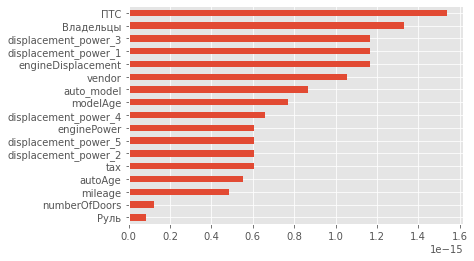

In [544]:
imp_cat = Series(mutual_info_classif(test[num_features], test['price'], discrete_features =True), index = num_features)
imp_cat.sort_values(inplace = True)
imp_cat.plot(kind = 'barh')

# print(num_features)
# print(cat_features)